In [ ]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

In [2]:
from openpiv import windef

import numpy as np
import os
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

In [3]:
import glob
file_list = sorted(glob.glob('../data/karman_16Hz_*.jpg'))
file_list = file_list[-2:]
file_list

[]

In [4]:
settings = windef.Settings()

# 'Data related settings'
# Folder with the images to process
# settings.filepath_images = '../data/'
# Folder for the outputs
settings.save_path = '../OpenPIV_results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
# settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
# settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

settings.filepath_images = '/home/user/Downloads/repos/openpiv-python/openpiv/examples/test10/'
settings.frame_pattern_a = 'B001_1.tif'
settings.frame_pattern_b = 'B001_2.tif'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'
# settings.ROI = (200,400,500,900)
# settings.ROI = (200,212,500,512)

# settings.deformation_method = 'symmetric' 
settings.deformation_method = 'second image'


settings.num_iterations = 1  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
# settings.windowsizes=(64, 32, 16, 6)
# settings.overlap=(32, 16, 8, 3)

settings.windowsizes=(32,32)
settings.overlap=(16,16)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)

# 'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_threshold = 1.25
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
settings.sig2noise_validate = False

# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = False
settings.scale_plot = 100  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation = False

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'


settings.replace_vectors = True
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4
settings.filter_kernel_size = 2  # kernel size for the localmean method



settings.MinMax_U_disp = (-10, 10)
settings.MinMax_V_disp = (-10, 10)

# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size = 2 # defines the size of the local median, it'll be 3 x 3

# New settings for version 0.23.2c
settings.image_mask = False

# Image mask properties
settings.dynamic_masking_method = 'None'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21



# Smoothing after the first pass
settings.smoothn = False #Enables smoothing of the displacemenet field
settings.smoothn_p = 0.5 # This is a smoothing parameter


settings.show_all_plots = False

In [5]:
%time
windef.piv(settings)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
global filter invalidated 3.0 vectors
std filter invalidated 11.0 vectors
median filter invalidated 1 vectors
Image Pair 1


In [6]:
from pivpy import pivpy, io, graphics
import xarray as xr

In [7]:
import glob

file_list = sorted(glob.glob('../OpenPIV_results/Open_PIV_results_'+str(settings.windowsizes[settings.num_iterations-1])+'_Test_1/*.txt'))
file_list

['../OpenPIV_results/Open_PIV_results_32_Test_1/field_A000.txt']

In [8]:
def read_data(file_list):
    data = []
    frame = 0
    for f in file_list:
        data.append(io.load_txt(f,frame=frame))
        frame += 1

    data = xr.concat(data,dim='t')
    data.attrs['units']= ['pix','pix','pix/dt','pix/dt']
    return data
# file_list = sorted(glob.glob('../OpenPIV_results/Open_PIV_results_6_Test_1/*.txt'))

In [9]:
import matplotlib.pyplot as plt
def plot_data(data):
    fig, ax = plt.subplots(1,1,figsize=(20,12))
    # for ax in axs:
    ax.quiver(data.x.data, data.y.data, data.u.isel(t=0).data.T, data.v.isel(t=0).data.T, color='r', scale=120)
    vort = (data.differentiate('x')['v'] - data.differentiate('y')['u'])
    s = ax.pcolor(data.x,data.y,vort.T.isel(t=0), shading='interp', vmin=-.3, vmax=.3,alpha=0.7)
    # s = ax.pcolor(data.x,data.y,data.w.T.isel(t=0), shading='interp', vmin=-.1, vmax=.1,alpha=0.7)
    # ax.invert_yaxis()
    ax.set_aspect(1)
    fig.colorbar(s, ax=ax,)
    plt.show()

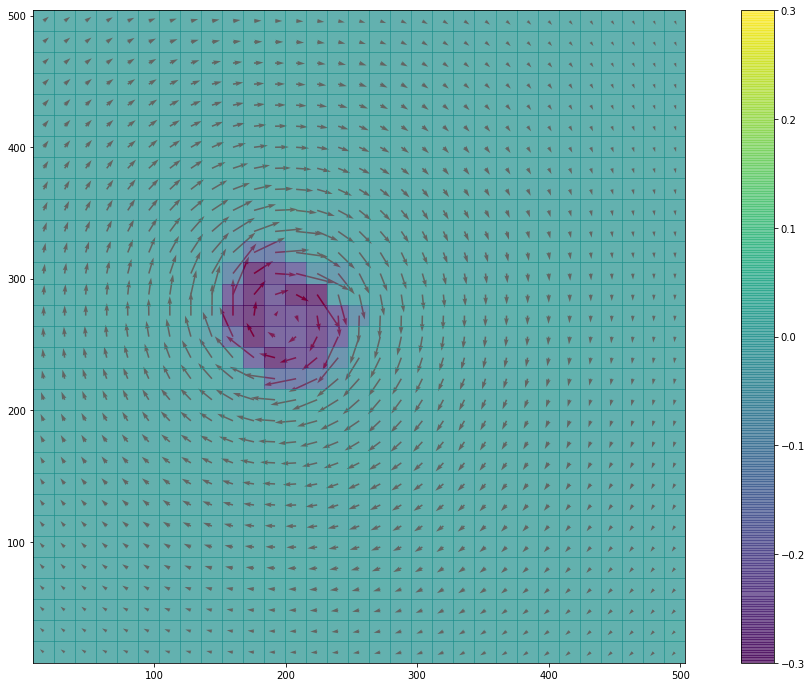

In [10]:
data = read_data(file_list)
plot_data(data)

In [11]:
data

<xarray.Dataset>
Dimensions:  (t: 1, x: 31, y: 31)
Coordinates:
  * x        (x) float64 16.0 32.0 48.0 64.0 80.0 ... 448.0 464.0 480.0 496.0
  * y        (y) float64 496.0 480.0 464.0 448.0 432.0 ... 64.0 48.0 32.0 16.0
  * t        (t) int64 0
Data variables:
    u        (x, y, t) float64 0.9635 0.9866 0.9936 ... -0.6609 -0.6342 -0.6043
    v        (x, y, t) float64 0.7933 0.8538 0.8973 ... -0.7644 -0.6542 -0.6479
    chc      (x, y, t) float64 1.369 1.387 1.391 1.408 ... 1.323 1.323 1.35
Attributes:
    variables:  ['x', 'y', 'u', 'v', 's2n']
    units:      ['pix', 'pix', 'pix/dt', 'pix/dt']
    dt:         1.0
    files:      ../OpenPIV_results/Open_PIV_results_32_Test_1/field_A000.txt

In [12]:
import openpiv.original_windef as original_windef

In [13]:
# %pdb

newsettings = original_windef.Settings()
for att in newsettings.__dict__:
    if hasattr(settings, att):
        setattr(newsettings,att,getattr(settings,att))



newsettings.do_sig2noise_validation = settings.sig2noise_validate
newsettings.extract_sig2noise = settings.sig2noise_validate
newsettings.save_folder_suffix = 'Test_2'
newsettings.normalized_correlation=False
# newsettings.num_iterations = settings.num_iterations

# settings.correlation_method='linear'
# settings.show_all_plots = True

attrs = vars(newsettings)
[item for item in attrs.items()]

[('filepath_images',
  '/home/user/Downloads/repos/openpiv-python/openpiv/examples/test10/'),
 ('save_path', '../OpenPIV_results/'),
 ('save_folder_suffix', 'Test_2'),
 ('frame_pattern_a', 'B001_1.tif'),
 ('frame_pattern_b', 'B001_2.tif'),
 ('ROI', 'full'),
 ('dynamic_masking_method', 'None'),
 ('dynamic_masking_threshold', 0.1),
 ('dynamic_masking_filter_size', 21),
 ('correlation_method', 'circular'),
 ('num_iterations', 1),
 ('windowsizes', (32, 32)),
 ('overlap', (16, 16)),
 ('subpixel_method', 'gaussian'),
 ('interpolation_order', 3),
 ('scaling_factor', 1),
 ('dt', 1),
 ('extract_sig2noise', False),
 ('sig2noise_method', 'peak2peak'),
 ('sig2noise_mask', 2),
 ('validation_first_pass', True),
 ('MinMax_U_disp', (-10, 10)),
 ('MinMax_V_disp', (-10, 10)),
 ('std_threshold', 5),
 ('median_threshold', 3),
 ('median_size', 2),
 ('do_sig2noise_validation', False),
 ('sig2noise_threshold', 1.25),
 ('replace_vectors', True),
 ('smoothn', False),
 ('smoothn_p', 0.5),
 ('filter_method', 'lo

In [14]:
%time
original_windef.piv(newsettings)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs
global filter invalidated 3.0 vectors
std filter invalidated 11.0 vectors
median filter invalidated 2 vectors
Image Pair 1


In [15]:
file_list = sorted(glob.glob('../OpenPIV_results/Open_PIV_results_'+str(newsettings.windowsizes[newsettings.num_iterations-1])+'_Test_2/*.txt'))
file_list

['../OpenPIV_results/Open_PIV_results_32_Test_2/field_A000.txt']

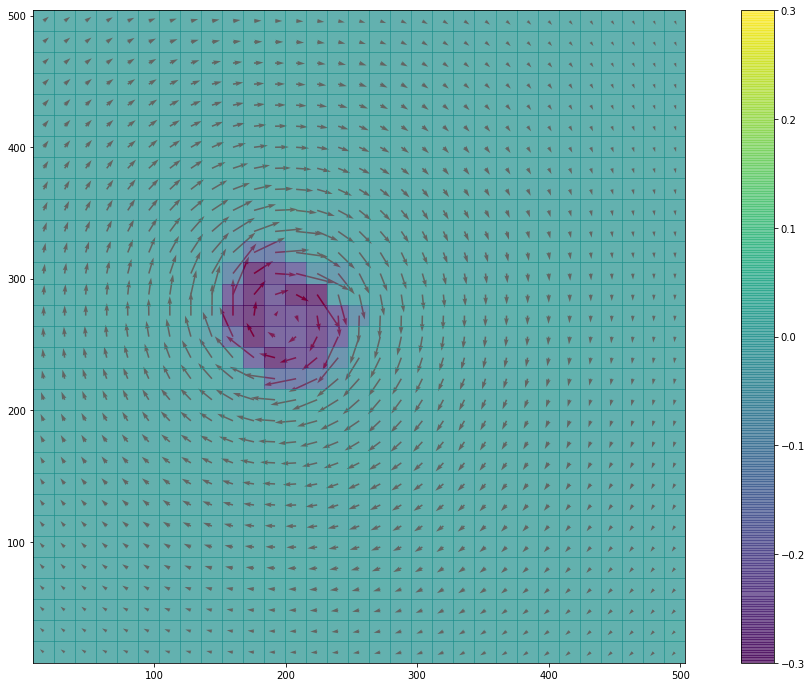

In [16]:
data = read_data(file_list)
plot_data(data)

In [17]:
data

<xarray.Dataset>
Dimensions:  (t: 1, x: 31, y: 31)
Coordinates:
  * x        (x) float64 16.0 32.0 48.0 64.0 80.0 ... 448.0 464.0 480.0 496.0
  * y        (y) float64 496.0 480.0 464.0 448.0 432.0 ... 64.0 48.0 32.0 16.0
  * t        (t) int64 0
Data variables:
    u        (x, y, t) float64 0.9635 0.9866 0.9936 ... -0.6609 -0.6342 -0.6043
    v        (x, y, t) float64 0.7933 0.8538 0.8973 ... -0.7644 -0.6542 -0.6479
    chc      (x, y, t) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    variables:  ['x', 'y', 'u', 'v', 's2n']
    units:      ['pix', 'pix', 'pix/dt', 'pix/dt']
    dt:         1.0
    files:      ../OpenPIV_results/Open_PIV_results_32_Test_2/field_A000.txt